In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

rootFolder = '/home/fernando/Dropbox/SUNY/2022/S1_netpyne/sim/'
# rootFolder = os.getcwd()
os.chdir(rootFolder)
print(rootFolder)
folder = os.listdir('cell_data/')
folder = sorted(folder)

savedata = 1 # Save Netpyne and BBP soma_voltage

/home/fernando/Dropbox/SUNY/2022/S1_netpyne/sim/


In [3]:
def loadTemplateName(cellnumber):     
    f = open(outFolder+'/template.hoc', 'r')
    for line in f.readlines():
        if 'begintemplate' in line:
            templatename = str(line)     
    templatename=templatename[:-1]        
    templatename=templatename[14:]
    return templatename

In [4]:
def runnetpyne(cellnumber):

    os.chdir(rootFolder)
    from netpyne import sim
    from netpyne import specs
    import pickle

    cfg = specs.SimConfig()     
    
    cfg.duration = timesimulation ## Duration of the sim, in ms  
    cfg.dt = 0.025
    cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
    cfg.hParams = {'celsius': 34, 'v_init': -65}  
    cfg.verbose = False
    cfg.createNEURONObj = True
    cfg.createPyStruct = True
    cfg.cvode_active = False
    cfg.cvode_atol = 1e-6
    cfg.cache_efficient = True
    cfg.printRunTime = 0.5
    
    cfg.includeParamsLabel = False
    cfg.printPopAvgRates = True
    cfg.checkErrors = False
    
#     allpops = ['L1_'+str(ii) for ii in range(1,13)]
    allpops = ['L1_3','L1_8']
    
    cfg.recordCells = allpops  # which cells to record from
    cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
    cfg.recordStim = True
    cfg.recordTime = True
    cfg.recordStep = 0.025            

    cfg.simLabel = 'S1_single'
    cfg.saveFolder = '.'
    # cfg.filename =                	## Set file output name
    cfg.savePickle = False         	## Save pkl file
    cfg.saveJson = False           	## Save json file
    cfg.saveDataInclude = ['simConfig', 'netParams'] ## 'simData' , 'simConfig', 'netParams'
    cfg.backupCfgFile = None 		##  
    cfg.gatherOnlySimData = False	##  
    cfg.saveCellSecs = False			##  
    cfg.saveCellConns = False		##  

    #------------------------------------------------------------------------------
    # Current inputs 
    #------------------------------------------------------------------------------
    cfg.addIClamp = True

    cfg.IClamp = []
    cfg.IClampnumber = 0
    
    for popName in allpops:
        cfg.IClamp.append({'pop': popName, 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': ampstim[cfg.IClampnumber]}) #pA
        cfg.IClampnumber=cfg.IClampnumber+1

    #------------------------------------------------------------------------------
    #------------------------------------------------------------------------------
    #------------------------------------------------------------------------------

    netParams = specs.NetParams()   # object of class NetParams to store the network parameters

    #------------------------------------------------------------------------------
    # Cell parameters
    #------------------------------------------------------------------------------
    #StochKv_deterministic.mod
    cellName = folder[cellnumber]
    cellTemplateName = loadTemplateName(cellnumber)
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper3.py',
        cellName='loadCell',
        cellInstance = True,
        cellArgs={'cellName': cellName, 'cellTemplateName': cellTemplateName})

    #------------------------------------------------------------------------------
    # Population parameters
    #------------------------------------------------------------------------------

#     netParams.popParams['L1_1'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#     netParams.popParams['L1_2'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_3'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#     netParams.popParams['L1_4'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#     netParams.popParams['L1_5'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#     netParams.popParams['L1_6'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#     netParams.popParams['L1_7'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_8'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#     netParams.popParams['L1_9'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#     netParams.popParams['L1_10'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#     netParams.popParams['L1_11'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#     netParams.popParams['L1_12'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 

    #------------------------------------------------------------------------------
    # Current inputs (IClamp)
    #------------------------------------------------------------------------------
    for j in range(cfg.IClampnumber):
        key ='IClamp'
        params = getattr(cfg, key, None)
        key ='IClamp'+str(j+1)
        params = params[j]
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}
    
    #------------------------------------------------------------------------------
    sim.createSimulateAnalyze(netParams, cfg)
    
    netpyneTraces = []
    netpyneTracesList = []
    for c in range(0,2):
        netpyneTraces.append(np.array(sim.simData['V_soma']['cell_'+ str(c)]))
        netpyneTracesList.append(list(sim.simData['V_soma']['cell_'+ str(c)]))        
 
    return netpyneTraces

In [5]:
def compareTraces(cellnumber):  

    import efel    

    netpyneTraces = runnetpyne(cellnumber)

    # plot traces
    fontsiz=18
    timeRange = [0, timesimulation]
    recordStep = 0.025
    # ~ ylim = [-100, 40]
    figSize = (24,24)
    fig = plt.figure(figsize=figSize)  # Open a new figure

    # fig.suptitle('%s' % (cellName), fontsize=15, fontweight='bold')
                    
    t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep) 
    
    for c in range(0,2):
        netpyneTrace = netpyneTraces[c]
        plt.subplot(12, 1, c+1)
        plt.ylabel('V (mV)', fontsize=fontsiz)
        plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=2.0, color='red', label='Step %d'%(int(c+0))+', NetPyNE')
        plt.xlabel('Time (ms)', fontsize=fontsiz)
        plt.xlim(0, timesimulation)
        # ~ plt.ylim(ylim)
        plt.grid(False)
        # plt.legend(loc='upper right', bbox_to_anchor=(0.20, 0.7))
    plt.ion()
    plt.tight_layout()
    
#     plt.savefig('/home/fernando/Figures_step2sec/comparison_traces_soma_voltage_4steps_%s.png' % cellName, facecolor = 'white' , dpi=300)

    return netpyneTraces

In [10]:
folder[555:560]

['L5_BTC_cNAC187_1',
 'L5_BTC_cNAC187_2',
 'L5_BTC_cNAC187_3',
 'L5_BTC_cNAC187_4',
 'L5_BTC_cNAC187_5']

CellNumber = 555
CellName = L5_BTC_cNAC187_1
TemplateName = cNAC187_L5_BTC_0a43e2f3e5
	1 
	1 
	1 
cNAC187_L5_BTC_0a43e2f3e5[0]

Start time:  2023-06-13 16:36:16.828218

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 2 
  Done; cell creation time = 0.02 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 2 
  Done; cell stims creation time = 0.00 s.
Recording 4 traces of 2 types on node 0
0.0s

Running simulation using NEURON for 1500.0 ms...
0.5s
1.0s
1.5s
  Done; run time = 8.91 s; real-time ratio: 0.17.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 2
  Connections: 0 (0.00 per cell)
  Spikes: 122 (40.67 Hz)
  Simulated time: 1.5 s; 1 workers
  Run time: 8.91 s
   L1_3 : 30.000 Hz
   L1_8 : 51.333 Hz
  Done; plotting time = 0.00 s

Total time = 8.95 s


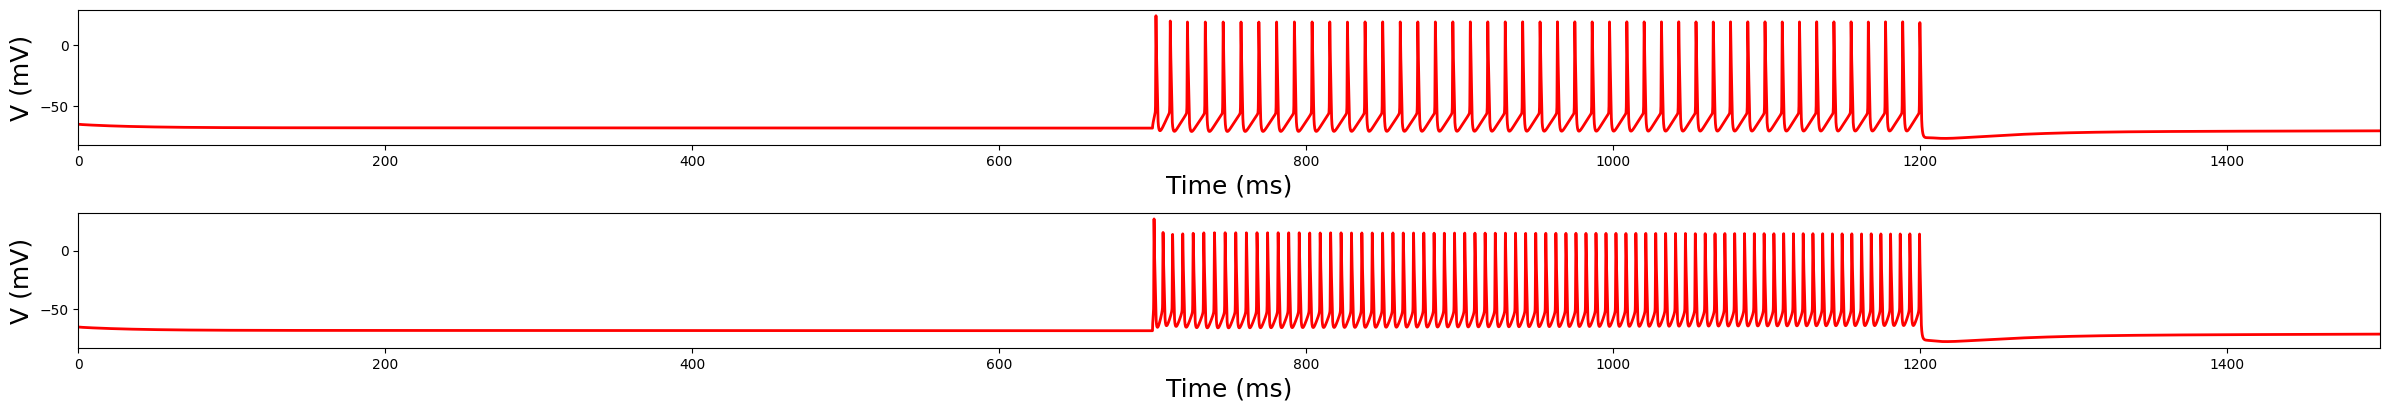

In [11]:
cellnumber = 555 # 760 #366 #10 # 265 #916 #369 # 
cellName = folder[cellnumber]
outFolder = rootFolder+'/cell_data/'+folder[cellnumber]
cellTemplateName = loadTemplateName(cellnumber)
print ("CellNumber = %d" % cellnumber)
print ("CellName = %s" % cellName)
print ("TemplateName = %s" % cellTemplateName)

# ampstim =  [0.1*ii for ii in range(1,13)]
ampstim =  [0.3, 0.8]

durationstim = 500
delaystim = 700
timesimulation = 1500
    
netpyneTraces = compareTraces(cellnumber)  

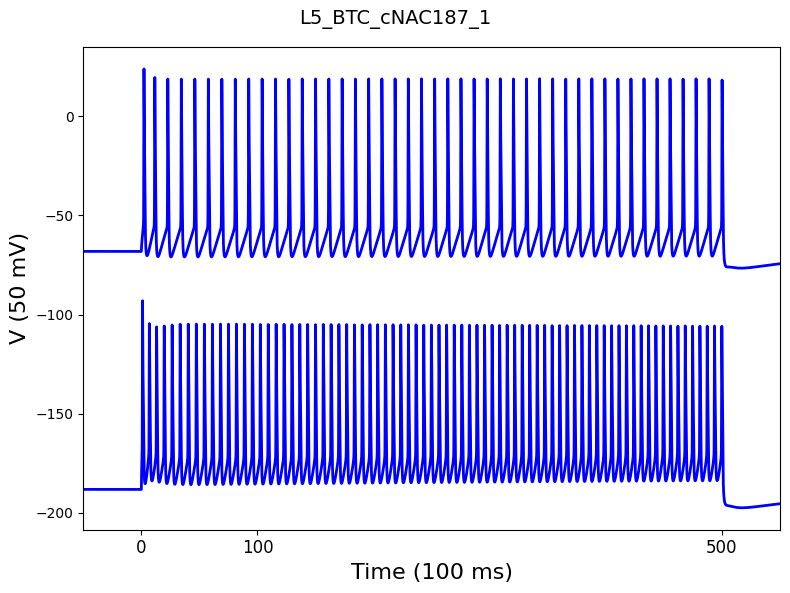

In [15]:
# plot both traces overlayed
fontsiz=16
timeRange = [0, timesimulation]
recordStep = 0.025
# ~ ylim = [-100, 40]
figSize = (8,6)
fig = plt.figure(figsize=figSize)  # Open a new figure

fig.suptitle('%s' % (cellName), fontsize=14)
                
t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep) 
 
for c in range(0,2):
    netpyneTrace = netpyneTraces[c]
    plt.ylabel('V (50 mV)', fontsize=fontsiz)
    plt.plot(t[:len(netpyneTrace)], netpyneTrace-c*120.0, linewidth=2.0, color='blue', label='NetPyNE')    
    plt.xlim(650, 1250)
#     plt.ylim(-90,50)
    plt.grid(False)
#     plt.legend(loc='upper right', bbox_to_anchor=(0.255, 1.01), fontsize=11)
    plt.xticks([700,800,1200],[0,100,500],fontsize=12)
#     plt.yticks([-80,-40,0,40], fontsize=12)
plt.xlabel('Time (100 ms)', fontsize=fontsiz)
plt.ion()
plt.tight_layout()
# os.chdir(rootFolder)
# os.chdir('../info/scripts_comparations/')
plt.savefig('/home/fernando/S1_HFO/runSubNets/Fig2/traces_soma_voltage_300and800pA_%s.png' % cellName, facecolor = 'white' , dpi=300)
# print ("Figure Saved in %s/comparison_traces_soma_voltage_4steps_%s.png" % (rootFolder,cellName))
# print ("https://bbp.epfl.ch/nmc-portal/microcircuit.html#/metype/%s/details" % cellName[:-5])
# plt.show()